Analyzing data coming from the script: 

C:\Users\David\Documents\GitHub\encoding\scripts\wm_representation\functions\IEM\Controls\trial_by_trial\trainT_testT_wm3.py

In [1]:
from linares_plot import *
import sys, os
import statsmodels.formula.api as smf
path_tools = 'C:\\Users\\David\\Documents\\GitHub\\encoding\\scripts\\wm_representation\\functions\\IEM\\tools'
sys.path.insert(1, path_tools)
from timecourse import *
from timecourse_c import *
from scipy import stats
from mlxtend.evaluate import permutation_test
import math

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
recons_path =  'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\recs_IEM_trainT_testT_wm3.npy' 

Reconstructions = np.load(recons_path, encoding='latin1')

print(np.shape(Reconstructions))
print(np.shape(Reconstructions[10]))

(24,)
(372, 16, 720)


In [4]:
beh_path =  'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\trainT_testT_behaviour.xlsx' 
xl = pd.ExcelFile(beh_path)
sheet_names = xl.sheet_names

print(len(sheet_names))
beh_x = pd.read_excel(beh_path, sheet_name=sheet_names[10])
print(np.shape(beh_x))

24
(372, 46)


In [5]:
## Indexes equivalences

Subjects=['d001', 'n001', 'b001', 'r001', 's001', 'l001']
brain_regions = ['visual','ips', 'pfc', 'broca']

index = 0
for Subject in Subjects:
    for Brain_region in brain_regions:
        print(index, Subject, Brain_region)
        index += 1
        


0 d001 visual
1 d001 ips
2 d001 pfc
3 d001 broca
4 n001 visual
5 n001 ips
6 n001 pfc
7 n001 broca
8 b001 visual
9 b001 ips
10 b001 pfc
11 b001 broca
12 r001 visual
13 r001 ips
14 r001 pfc
15 r001 broca
16 s001 visual
17 s001 ips
18 s001 pfc
19 s001 broca
20 l001 visual
21 l001 ips
22 l001 pfc
23 l001 broca


In [6]:
all_beh = []
for idx in [0, 4, 8, 12, 16, 10]:
    beh_x = pd.read_excel(beh_path, sheet_name=sheet_names[idx])
    all_beh.append(beh_x)
    
Beh = pd.concat(all_beh)
Beh.head(5)

,Unnamed: 0,type,delay1,delay2,T,NT1,NT2,Dist,Dist_NT1,Dist_NT2,...,T_alone,dist_alone,T_close,dist_close,subject,session,run,session_run,Condition,brain_region
0,0,1,0.2,11.8,142,241,321,126.0,214.7,64.0,...,321,64,142,126.0,d001,10,1,10_1,1_0.2,visual
1,1,3,7.0,12.0,204,51,114,311.0,65.1,134.2,...,204,311,51,65.1,d001,10,1,10_1,2_7,visual
2,2,3,7.0,5.0,63,200,139,305.0,216.7,159.5,...,63,305,200,216.7,d001,10,1,10_1,1_7,visual
3,3,3,7.0,12.0,296,223,156,53.0,204.2,126.5,...,296,53,223,204.2,d001,10,1,10_1,2_7,visual
4,4,3,0.2,11.8,312,42,232,113.0,29.4,206.6,...,312,113,42,29.4,d001,10,1,10_1,1_0.2,visual


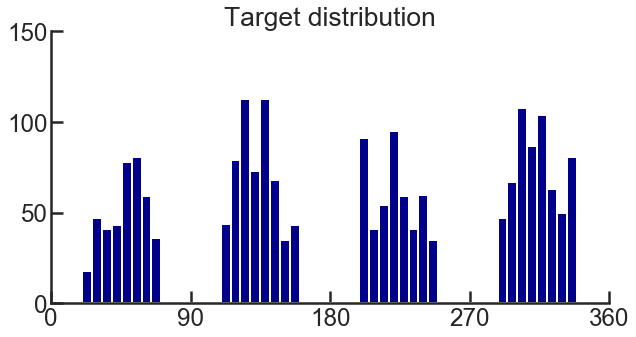

In [167]:
plt.figure(figsize=(10,5))
plt.title('Target distribution')
plt.hist(Beh['T'].values, bins=50, color='darkblue');
plt.xticks([0,90, 180, 270, 360]);
plt.yticks([0,50,100,150]);
## It is 20 and 20!! :S :S
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction


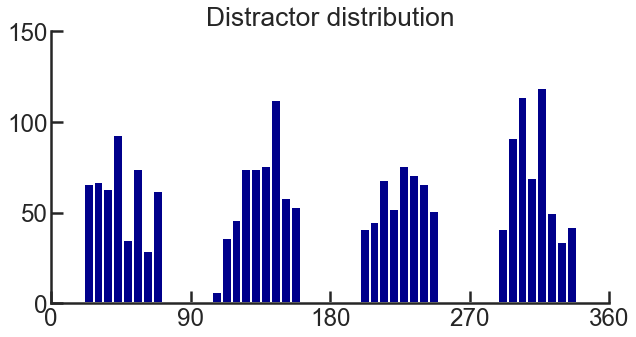

In [168]:
plt.figure(figsize=(10,5))
plt.title('Distractor distribution')
plt.hist(Beh['Dist'].values, bins=50, color='darkblue');
plt.xticks([0,90, 180, 270, 360]);
plt.yticks([0,50,100,150]);
## It is 20 and 20!! :S :S
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction

#### Plot heatmap of one condition in one subject

In [9]:
idx_ = 4 ##  0 --> n001 visual

reconstr_trials = np.array(Reconstructions[idx_])
beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])

print(np.shape(reconstr_trials))
print(np.shape(beh))

(372, 16, 720)
(372, 46)


372
96
(96, 16, 720)
(16, 720)


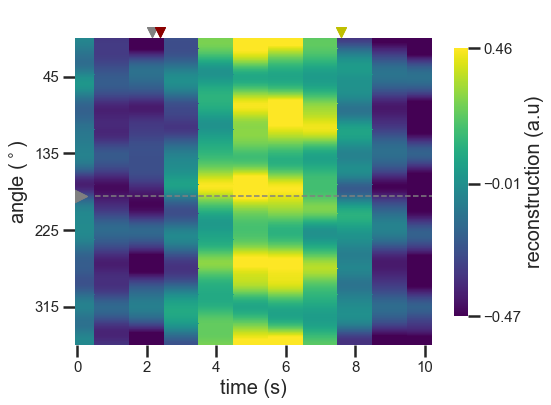

In [10]:
Condition_ = '1_0.2'
bool_condition = np.array(beh.Condition==Condition_)
print(len(bool_condition))
print(sum(bool_condition))

reconstr_trials_cond = reconstr_trials[bool_condition]
print(np.shape(reconstr_trials_cond))

mean_reconstr_cond = reconstr_trials_cond.mean(axis=0)
print(np.shape(mean_reconstr_cond))


dfx = pd.DataFrame(mean_reconstr_cond.T)

Representation_heatmap(dfx, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [41]:
def decoder_TR(rec, N=720):
    ##rec is the reconstruction of a TR 
    ##
    Sin = np.mean(np.sin(np.linspace(0, 2*np.pi, N)) * rec)
    Cos = np.mean(np.cos(np.linspace(0, 2*np.pi, N)) * rec)

    Tan = Sin/Cos
    decoding_strength = abs(C)

    if (Sin>0) & (Cos>0):
        angle = np.degrees(math.atan(Tan))
    if (Sin>0) & (Cos<0):
        angle = np.degrees(math.atan(Tan)) + 180
    if (Sin<0) & (Cos<0):
        angle = np.degrees(math.atan(Tan)) + 180
    if (Sin<0) & (Cos>0):
        angle = np.degrees(math.atan(Tan)) + 360

    #   
    return angle, decoding_strength
        

    

(322.4304383962007, 0.46805756566608914)

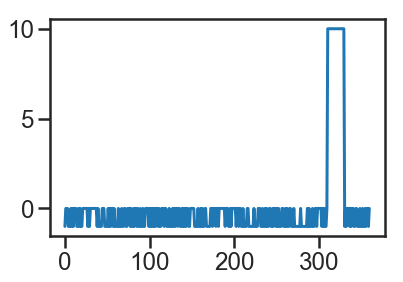

In [43]:
N=360

j = np.array([3.2 for i in range(0, N)])
j = np.random.randint(-1,1, N)
j[310:330]=10
plt.plot(j)


decoder_TR(j, N=360)


321.37824946326725
0.46805756566608914


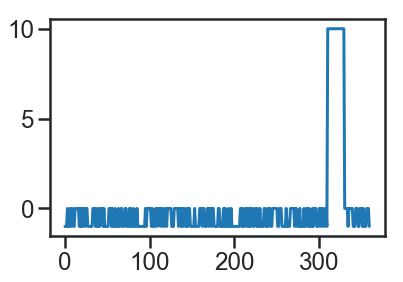

In [39]:
### Get the degree decoded

N=720

j = np.array([3.2 for i in range(0, N)])
j = np.random.randint(-1,1, N)
j[310:330]=10
plt.plot(j)

S = np.mean(np.sin(np.linspace(0, 2*np.pi, N)) * j)
C = np.mean(np.cos(np.linspace(0, 2*np.pi, N)) * j)

T = S/C

if (S>0) & (C>0):
    angle = np.degrees(math.atan(T))
if (S>0) & (C<0):
    angle = np.degrees(math.atan(T)) + 180
if (S<0) & (C<0):
    angle = np.degrees(math.atan(T)) + 180
if (S<0) & (C>0):
    angle = np.degrees(math.atan(T)) + 360
    
#   
print(angle)
print(abs(C))

#### Plot a condition, all subjects

In [171]:
Condition_ = '1_0.2'
idx_visual = [0,4,8,12,16,20]
idx_ips = [1,5,9,13,17,21]
idx_pfc = [2,6,10,14,18,22]
idx_broca = [3,7,11,15,19,23]

idx_area = idx_visual

In [172]:
frames=[]

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    #
    mean_reconstr_cond = reconstr_trials_cond.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames.append(dfx)



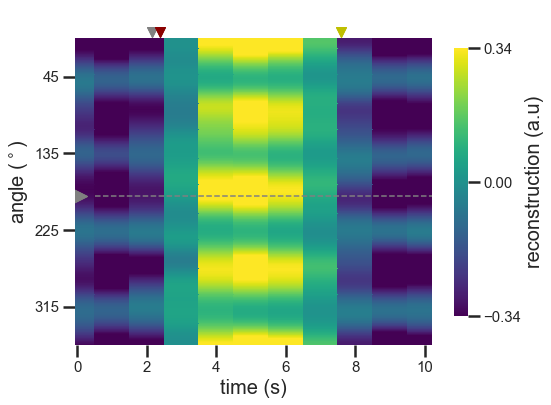

In [173]:
dfx_ = pd.concat(frames).groupby(level=0).mean()
Representation_heatmap(dfx_, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

### Shuffle (pick randomly one of the 3 targets)

In [174]:
n_shuffles=5

In [175]:
frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=1)
            ###
            ##align to other 
            ## 1 - Other target! (makes no sense! all equally relevant!)
            rch = np.random.choice([0,1,2]) ## T_alone es igual a a A_DVF, por lo que alineo a uno de los otros 2
            if rch == 0:
                colu_ = 'A_DC'
            elif rch == 1:
                colu_ = 'A_DF'
            elif rch == 2:
                colu_ = 'A_DVF'

            new_angle = reconstr_beh_cond[colu_].iloc[trial]
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=1)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    
        
        
        
        

(445, 16, 720)
(480, 16, 720)
(480, 16, 720)
(370, 16, 720)
(415, 16, 720)
(400, 16, 720)


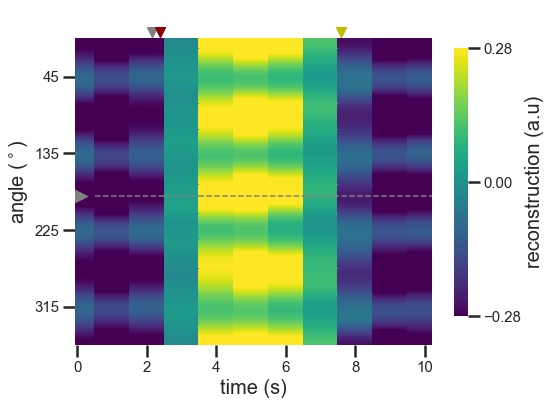

In [176]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

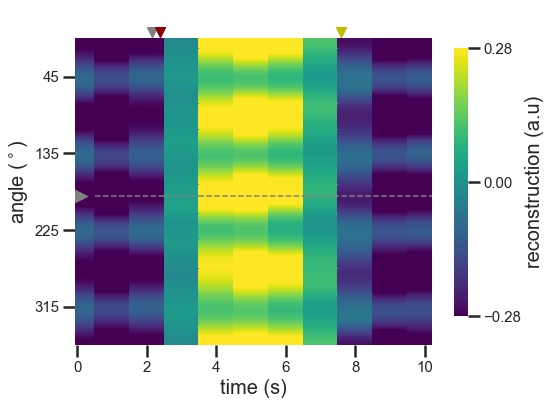

In [177]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [178]:
#substr_shuffle = dfx_ - dfx_sh
#Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

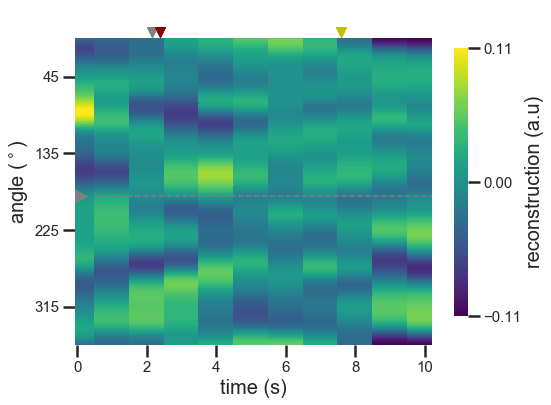

In [179]:
## Do the shuffle substraction individually (it does not make a difference)

frames_signal_sh = []
for subj in range(len(frames)):
    signal = frames[subj]
    shuff = frames_sh[subj]
    subst = signal -shuff
    frames_signal_sh.append(subst)

    
dfx_subst = pd.concat(frames_signal_sh).groupby(level=0).mean().round(3)
Representation_heatmap(dfx_subst, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

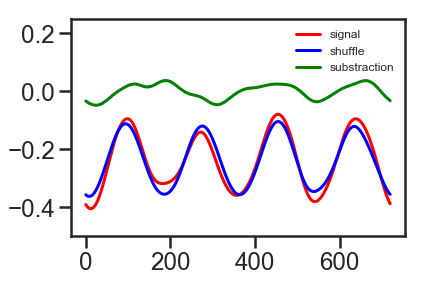

In [180]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(dfx_subst.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

# Different decoding methods

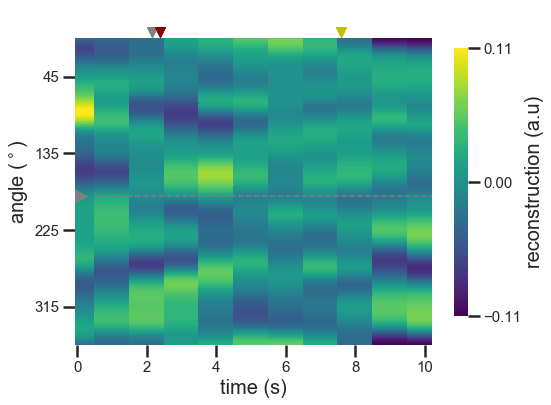

In [181]:
Representation_heatmap(dfx_subst, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

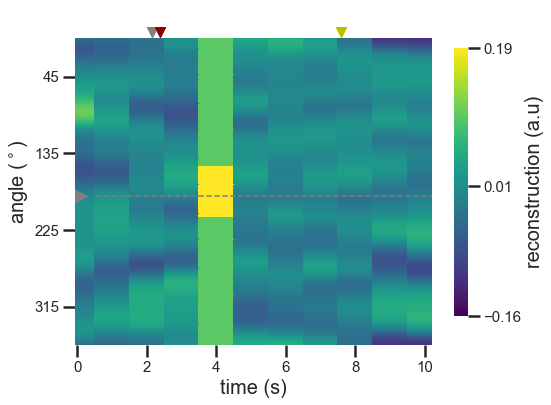

In [182]:
dfx_subst2 = dfx_subst.copy()
dfx_subst2.iloc[:, 4] = 0.1
dfx_subst2.iloc[300:420, 4] = 0.85
Representation_heatmap(dfx_subst2, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

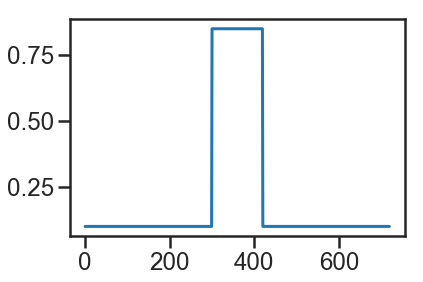

In [183]:
plt.plot(dfx_subst2.iloc[:,4])

83.14451768936422

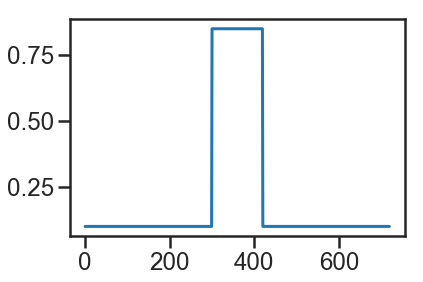

In [184]:
dfx_subst2.iloc[:, 4] = 0.1
dfx_subst2.iloc[300:420, 4] = 0.85
plt.plot(dfx_subst2.iloc[:,4])

R = np.mean(np.cos(np.arange(0,720)*2*np.pi/720 - np.pi) * dfx_subst2.iloc[:, 4])
np.degrees(math.acos(R))

60.16838164032247

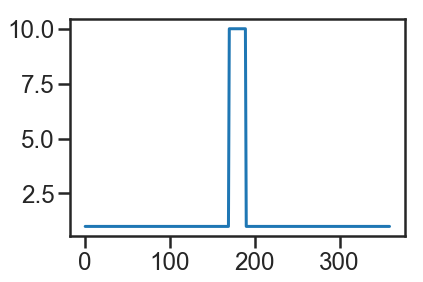

In [185]:
j = np.array([1 for i in range(0, 360)])
j[170:190]=10
plt.plot(j)

R = np.mean(np.cos(np.arange(0,360)*2*np.pi/360 - np.pi) * j)
np.degrees(math.acos(R))

In [186]:
np.cos(np.pi)

-1.0

119.64864070654043

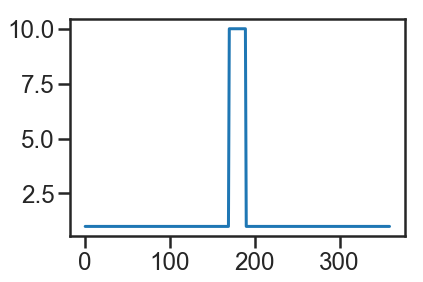

In [187]:
j = np.array([1 for i in range(0, 360)])
j[170:190]=10
plt.plot(j)

R = np.mean(np.cos(np.linspace(0, 2*np.pi, 360)) * j)
rad = math.acos(R)
np.degrees(rad)

60.35135929345958

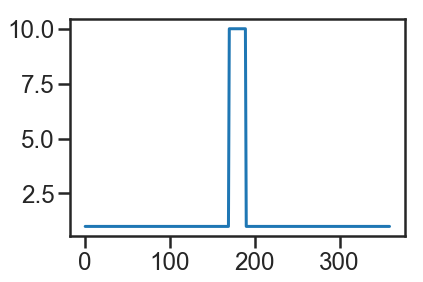

In [188]:
j = np.array([1 for i in range(0, 360)])
j[170:190]=10
plt.plot(j)

R = np.mean(np.cos(np.linspace(-np.pi, np.pi, 360)) * j)
rad = math.acos(R)
np.degrees(rad)

240.35135929345958
-119.64864070654043


240.4

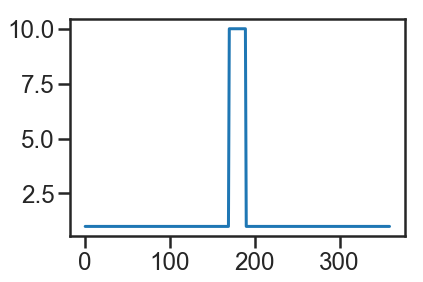

In [189]:
j = np.array([1 for i in range(0, 360)])
j[170:190]=10
plt.plot(j)

R = np.mean(np.cos(np.linspace(-np.pi, np.pi, 360)) * j)
rad = math.acos(R)
print(np.degrees(rad + np.pi))
print(np.degrees(rad - np.pi))
360-119.6

In [ ]:
math.acos --> -1, 1
np.degrees(0, 2pi)

-2.5639158613077915e-14

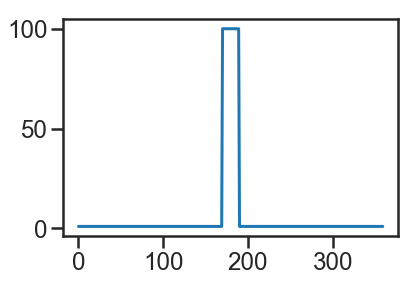

In [94]:
j = np.array([1 for i in range(0, 360)])
j[170:190]=100
plt.plot(j)

C = np.mean(np.cos(np.linspace(0, 2*np.pi, 360)) * j)
S = np.mean(np.sin(np.linspace(0, 2*np.pi, 360)) * j)
T = S/C
rad = math.atan(T)
np.degrees(rad)

-1.736846228627859e-14
-3.4197323935095734e-11


ValueError: math domain error

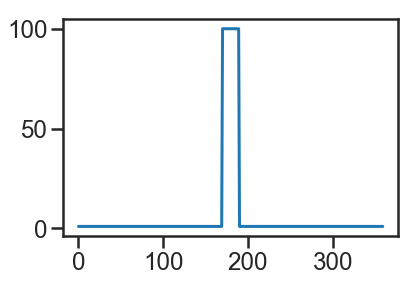

In [101]:
j = np.array([1 for i in range(0, 360)])
j[170:190]=100
plt.plot(j)

S = np.sum(np.sin(np.linspace(-np.pi, np.pi, 360)) * j)
C = np.sum(np.cos(np.linspace(-np.pi, np.pi, 360)) * j)

T = S/C

print(np.degrees(math.atan(T)))
print(np.degrees(math.asin(S)))
print(np.degrees(math.acos(C)))



71.37571830115242
67.0126914224179


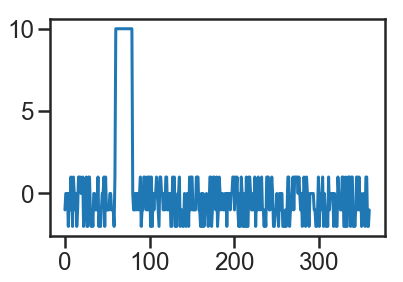

In [231]:
N=360

j = np.array([3.2 for i in range(0, N)])
j = np.random.randint(-2,2, 360)
j[60:80]=10
plt.plot(j)

S = np.sum(np.sin(np.linspace(0, 2*np.pi, N)) * j)
C = np.sum(np.cos(np.linspace(0, 2*np.pi, N)) * j)

T = S/C

if (S>0) & (C>0):
    angle = np.degrees(math.atan(T))
if (S>0) & (C<0):
    angle = np.degrees(math.atan(T)) + 180
if (S<0) & (C<0):
    angle = np.degrees(math.atan(T)) + 180
if (S<0) & (C>0):
    angle = np.degrees(math.atan(T)) + 360
    
#   
#print(S)
#print(C)
print(angle)
print(C)

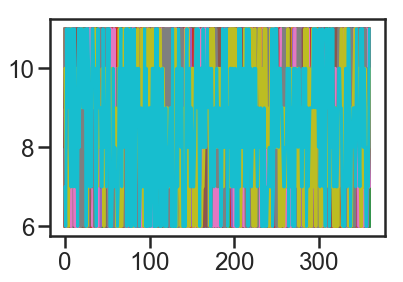

In [240]:

a=[]


for i in range(100):
    N=360

    j = np.array([3.2 for i in range(0, N)])
    j = np.random.randint(6,12, 360)
    #j[60:80]=10
    plt.plot(j)

    S = np.sum(np.sin(np.linspace(0, 2*np.pi, N)) * j)
    C = np.sum(np.cos(np.linspace(0, 2*np.pi, N)) * j)

    T = S/C

    if (S>0) & (C>0):
        angle = np.degrees(math.atan(T))
    if (S>0) & (C<0):
        angle = np.degrees(math.atan(T)) + 180
    if (S<0) & (C<0):
        angle = np.degrees(math.atan(T)) + 180
    if (S<0) & (C>0):
        angle = np.degrees(math.atan(T)) + 360

    #   
    #print(S)
    #print(C)
    #print(angle)
    a.append(C)

(array([ 2.,  7., 13., 15., 19., 16., 10., 11.,  4.,  3.]),
 array([-50.02627866, -38.17765231, -26.32902595, -14.4803996 ,
         -2.63177324,   9.21685312,  21.06547947,  32.91410583,
         44.76273219,  56.61135854,  68.4599849 ]),
 <a list of 10 Patch objects>)

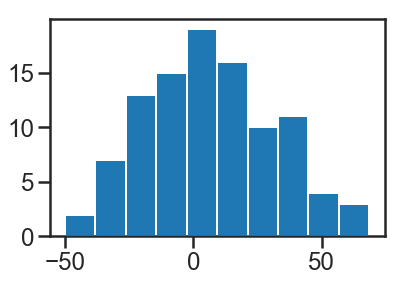

In [241]:
plt.hist(a)

145.56188290946295
65.69191075303782


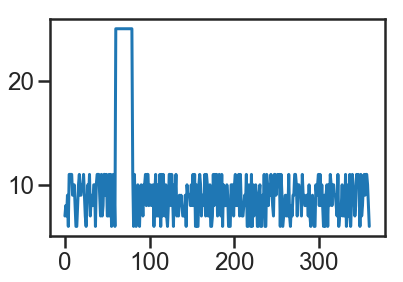

In [250]:
N=360

j = np.array([3.2 for i in range(0, N)])
j = np.random.randint(6,12, 360)
j[60:80]=25
plt.plot(j)

S = np.sum(np.sin(np.linspace(0, 2*np.pi, N)) * j)
C = np.sum(np.cos(np.linspace(0, 2*np.pi, N)) * j)

T = S/C

if (S>0) & (C>0):
    angle = np.degrees(math.atan(T))
if (S>0) & (C<0):
    angle = np.degrees(math.atan(T)) + 180
if (S<0) & (C<0):
    angle = np.degrees(math.atan(T)) + 180
if (S<0) & (C>0):
    angle = np.degrees(math.atan(T)) + 360

#   
#print(S)
print(C)
print(angle)


7445.989446794889
2756.3016923994865
69.68682550532593


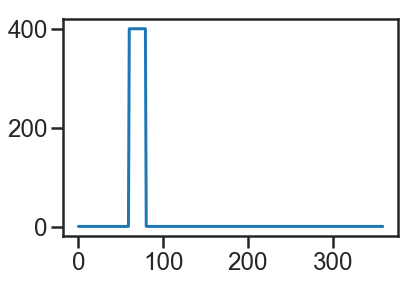

In [222]:
N=360

j = np.array([1 for i in range(0, N)])
#j = 1+np.random.rand(360,1)
j[60:80]=400
plt.plot(j)

S = np.sum(np.sin(np.linspace(0, 2*np.pi, N)) * j)
C = np.sum(np.cos(np.linspace(0, 2*np.pi, N)) * j)

T = S/C

if (S>0) & (C>0):
    angle = np.degrees(math.atan(T))
if (S>0) & (C<0):
    angle = np.degrees(math.atan(T)) + 180
if (S<0) & (C<0):
    angle = np.degrees(math.atan(T)) + 180
if (S<0) & (C>0):
    angle = np.degrees(math.atan(T)) + 360
    
#   
print(S)
print(C)
print(angle)



4.761524150677136


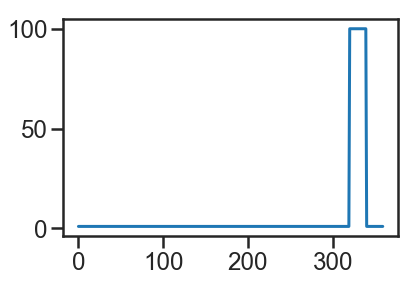

In [200]:
N=360

j = np.array([1 for i in range(0, N)])
j[320:340]=100
plt.plot(j)

angles_ = np.cos(np.linspace(0, 2*np.pi, N))
strength = np.mean(angles_ * j)

print(strength)

In [131]:
print(S)
print(C)

-6.746030690706146
5.629926609520759


In [121]:
T

1.1759973204906657

In [99]:
C

1968.932158266668

-1.85125810052344


ValueError: math domain error

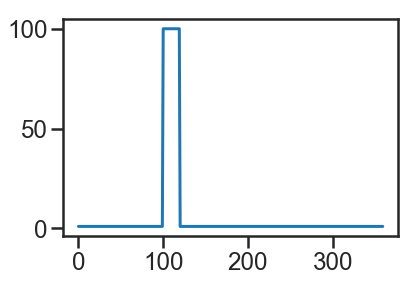

In [90]:
j = np.array([1 for i in range(0, 360)])
j[100:120]=100
plt.plot(j)

R = np.mean(np.cos(np.linspace(0, 2*np.pi, 360)) * j)
print(R)
rad = math.acos(R)
np.degrees(rad)

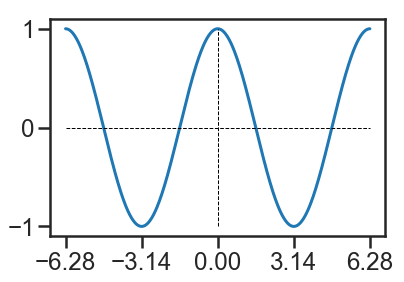

In [87]:
## cos function
plt.plot(np.linspace(-2*np.pi, 2*np.pi, 500), np.cos(np.linspace(-2*np.pi, 2*np.pi, 500)))
plt.plot([-2*np.pi, 2*np.pi], [0, 0], 'k--', linewidth=1)
plt.plot([0,0], [-1,1], 'k--', linewidth=1)
plt.xticks([-2*np.pi, -np.pi, 0, np.pi, np.pi*2]);

In [69]:
math.acos(1)

0.0

In [ ]:
math.acos()

In [54]:
np.degrees(0)
np.degrees(np.pi*2)

360.0

In [29]:
for TR in range(0,16):
    dec_ =np.mean(np.cos(np.arange(0,720)*2*np.pi/720) * dfx_subst2.iloc[:, TR])
    print(np.degrees(dec_))

0.040608433176328326
-0.2267144018101253
-0.20038996617836136
-0.041846780888595184
-6.839136493024932
0.021671954384618247
0.20193999348043912
0.1339732276750767
-0.20478927493033136
-0.41691953470719667
-0.052063355337076775
0.06246387033428924
-0.034308516796081774
-0.03269353607934028
-0.046603579266109564
0.06447324568515951


0.11936544979658327


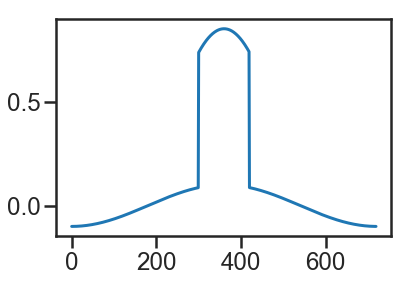

In [30]:
plt.plot(np.cos(np.arange(0,720)*2*np.pi/720 - np.pi) * dfx_subst2.iloc[:, 4])
dec = np.mean(np.cos(np.arange(0,720)*2*np.pi/720 - np.pi) * dfx_subst2.iloc[:, 4])
print(dec)


0      -0.000000
1      -0.050068
2      -0.100124
3      -0.150157
4      -0.200156
         ...    
715   -35.765648
716   -35.827953
717   -35.887559
718   -35.944455
719   -35.998629
Name: 4, Length: 720, dtype: float64

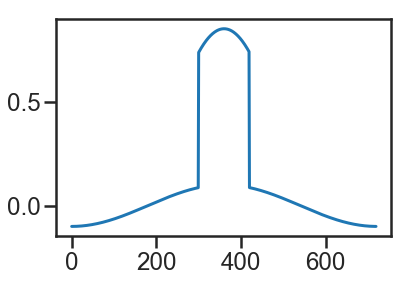

In [31]:
A = np.cos(np.arange(0,720)*2*np.pi/720 - np.pi) * dfx_subst2.iloc[:, 4]
plt.plot(A)
A * np.linspace(0,360,720)

In [32]:
Vectors = []
for i in range(0, 720):
    linespace = np.linspace(0,2*np.pi, 720) - np.pi
    x = linespace[i]
    vector_ = np.array([np.cos(x), np.sin(x)])
    y = dfx_subst2.iloc[i, 4]
    prod_vector = np.round(vector_ * y,3)
    #prod = x*y
    #vector = np.array([x,y])
    Vectors.append(prod_vector)

In [33]:
Vectors

[array([-0.1, -0. ]),
 array([-0.1  , -0.001]),
 array([-0.1  , -0.002]),
 array([-0.1  , -0.003]),
 array([-0.1  , -0.003]),
 array([-0.1  , -0.004]),
 array([-0.1  , -0.005]),
 array([-0.1  , -0.006]),
 array([-0.1  , -0.007]),
 array([-0.1  , -0.008]),
 array([-0.1  , -0.009]),
 array([-0.1 , -0.01]),
 array([-0.099, -0.01 ]),
 array([-0.099, -0.011]),
 array([-0.099, -0.012]),
 array([-0.099, -0.013]),
 array([-0.099, -0.014]),
 array([-0.099, -0.015]),
 array([-0.099, -0.016]),
 array([-0.099, -0.017]),
 array([-0.098, -0.017]),
 array([-0.098, -0.018]),
 array([-0.098, -0.019]),
 array([-0.098, -0.02 ]),
 array([-0.098, -0.021]),
 array([-0.098, -0.022]),
 array([-0.097, -0.023]),
 array([-0.097, -0.023]),
 array([-0.097, -0.024]),
 array([-0.097, -0.025]),
 array([-0.097, -0.026]),
 array([-0.096, -0.027]),
 array([-0.096, -0.028]),
 array([-0.096, -0.028]),
 array([-0.096, -0.029]),
 array([-0.095, -0.03 ]),
 array([-0.095, -0.031]),
 array([-0.095, -0.032]),
 array([-0.095, -0

In [34]:
pop = np.array(Vectors).mean(axis=0)
import math
math.acos(np.round(pop,3)[0])

1.4515136619631646

In [161]:
np.round(vector_ * y,2)

array([-0.04,  0.  ])

In [151]:
pop = np.array(Vectors).sum(axis=0)
pop

array([-3.26849658e-13,  9.91410000e+01])

In [147]:
pop = np.array(Vectors).sum(axis=0)
pop

array([2261.94671058,   99.141     ])

In [155]:
np.cos(), np.sin()

1.0

In [143]:
Vectors

[array([-3.14159265,  0.036     ]),
 array([-3.13285387,  0.036     ]),
 array([-3.12411509,  0.037     ]),
 array([-3.1153763,  0.037    ]),
 array([-3.10663752,  0.037     ]),
 array([-3.09789874,  0.037     ]),
 array([-3.08915995,  0.037     ]),
 array([-3.08042117,  0.037     ]),
 array([-3.07168239,  0.037     ]),
 array([-3.0629436,  0.037    ]),
 array([-3.05420482,  0.037     ]),
 array([-3.04546604,  0.036     ]),
 array([-3.03672725,  0.036     ]),
 array([-3.02798847,  0.035     ]),
 array([-3.01924969,  0.035     ]),
 array([-3.0105109,  0.034    ]),
 array([-3.00177212,  0.033     ]),
 array([-2.99303333,  0.032     ]),
 array([-2.98429455,  0.031     ]),
 array([-2.97555577,  0.03      ]),
 array([-2.96681698,  0.029     ]),
 array([-2.9580782,  0.028    ]),
 array([-2.94933942,  0.027     ]),
 array([-2.94060063,  0.026     ]),
 array([-2.93186185,  0.025     ]),
 array([-2.92312307,  0.023     ]),
 array([-2.91438428,  0.022     ]),
 array([-2.9056455,  0.021    ]),
 a

In [101]:
np.add(np.cos(np.arange(0,720)*2*np.pi/720 - np.pi) * dfx_subst2.iloc[:, 4])/720

TypeError: ufunc() missing 1 of 2required positional argument(s)

In [132]:
pop = np.array(Vectors).mean(axis=0)
pop

array([3.14159265, 0.13769583])

In [123]:
Vectors

[array([0.   , 0.036]),
 array([0.00873878, 0.036     ]),
 array([0.01747757, 0.037     ]),
 array([0.02621635, 0.037     ]),
 array([0.03495513, 0.037     ]),
 array([0.04369392, 0.037     ]),
 array([0.0524327, 0.037    ]),
 array([0.06117148, 0.037     ]),
 array([0.06991027, 0.037     ]),
 array([0.07864905, 0.037     ]),
 array([0.08738783, 0.037     ]),
 array([0.09612662, 0.036     ]),
 array([0.1048654, 0.036    ]),
 array([0.11360418, 0.035     ]),
 array([0.12234297, 0.035     ]),
 array([0.13108175, 0.034     ]),
 array([0.13982054, 0.033     ]),
 array([0.14855932, 0.032     ]),
 array([0.1572981, 0.031    ]),
 array([0.16603689, 0.03      ]),
 array([0.17477567, 0.029     ]),
 array([0.18351445, 0.028     ]),
 array([0.19225324, 0.027     ]),
 array([0.20099202, 0.026     ]),
 array([0.2097308, 0.025    ]),
 array([0.21846959, 0.023     ]),
 array([0.22720837, 0.022     ]),
 array([0.23594715, 0.021     ]),
 array([0.24468594, 0.02      ]),
 array([0.25342472, 0.018     ])

In [89]:
np.mean(np.cos(np.arange(0,720)*2*np.pi/720) * dfx_subst2.iloc[:, 4])

-0.13310652622543553

In [75]:
np.degrees(1.9)

108.8619810748564

In [64]:
for i in range(len(dfx_subst.iloc[:, 0])):
    print(i*2*np.pi/720)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

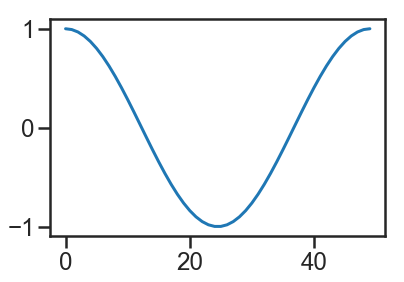

In [61]:
plt.plot([np.cos(x) for x in np.linspace(0, 2*np.pi)])

In [ ]:
## Convert to positive with POS function

In [ ]:
dfx3 = dfx_subst.copy()

for col in range(np.shape(dfx)[1]):
    dfx3.iloc[:, col] = Pos_IEM2(substr_shuffle.iloc[:,col].values) 


Representation_heatmap(dfx3, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)
plt.plot(dfx3.iloc[360-10:360+10, :].mean(axis=0))

# Different Shuffle methods

### Shuffle (pick randomly one of the other 2 targets)

In [33]:
frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=1)
            ###
            ##align to other 
            ## 1 - Other target! (makes no sense! all equally relevant!)
            rch = np.random.choice([0,1]) ## T_alone es igual a a A_DVF, por lo que alineo a uno de los otros 2
            if rch == 0:
                colu_ = 'A_DC'
            elif rch == 1:
                colu_ = 'A_DF'
                
            new_angle = reconstr_beh_cond[colu_].iloc[trial]
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=1)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    
        
        
        
        

(89, 16, 720)
(96, 16, 720)
(96, 16, 720)
(74, 16, 720)
(83, 16, 720)
(80, 16, 720)


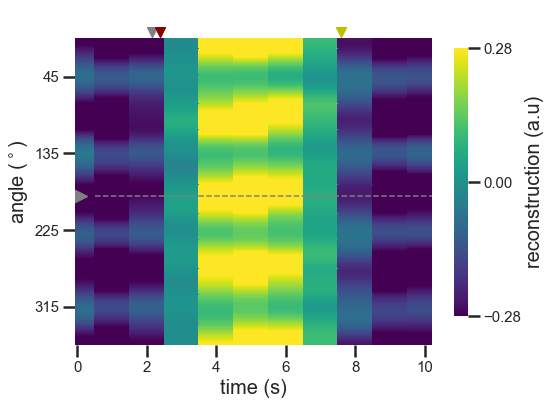

In [34]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

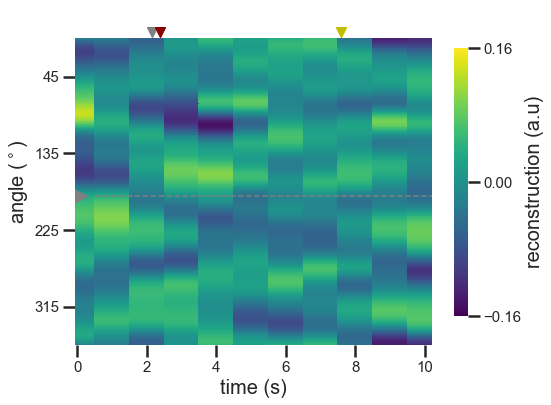

In [35]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

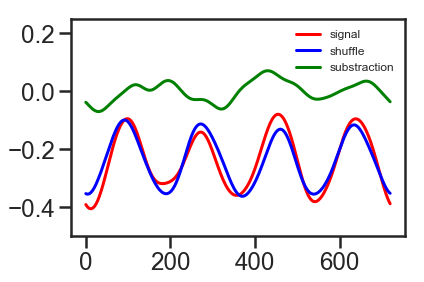

In [36]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

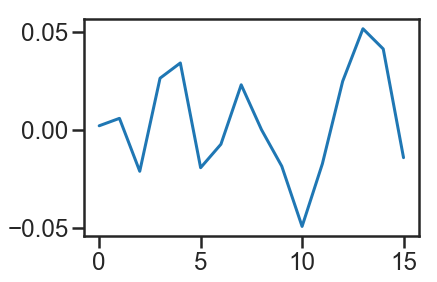

In [37]:
plt.plot(substr_shuffle.iloc[360-10:360+10, :].mean(axis=0))

### Shuffle (pick a random location 1-360)

In [48]:
frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=1)
            ###
            ##align to other 
            ## 1 - Random location 1-360
            new_angle = np.random.randint(0,359)
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=1)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    

(89, 16, 720)
(96, 16, 720)
(96, 16, 720)
(74, 16, 720)
(83, 16, 720)
(80, 16, 720)


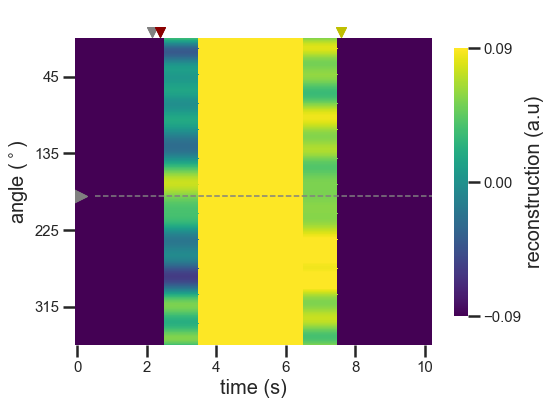

In [49]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

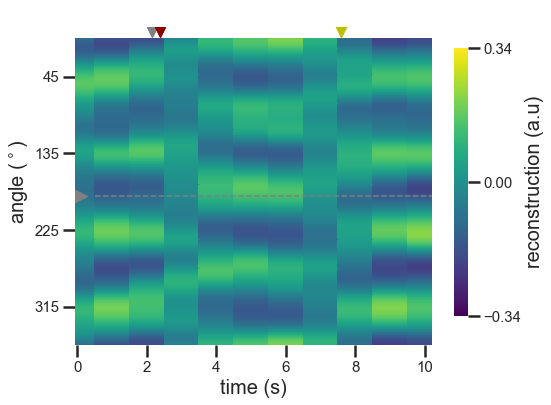

In [50]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

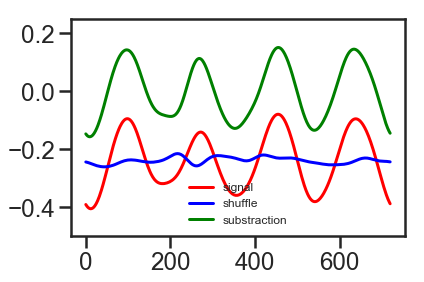

In [51]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

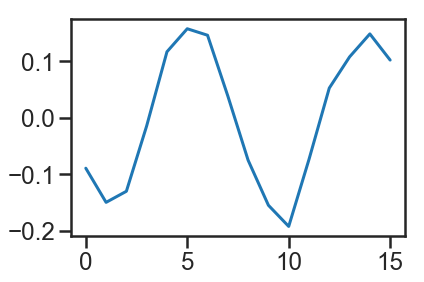

In [52]:
plt.plot(substr_shuffle.iloc[360-10:360+10, :].mean(axis=0))

### Shuffle (pick a random inside the free quadrant)

In [43]:
frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=1)
            ###
            ##align to other 
            ## 3- random in quadrant alone
            q_alone = list(set([1,2,3,4]) - set([reconstr_beh_cond['Q_DC'].iloc[trial], reconstr_beh_cond['Q_DF'].iloc[trial], reconstr_beh_cond['Q_DVF'].iloc[trial]]))[0]
            if q_alone==1:
                new_angle = np.random.randint(0,89)
            if q_alone==2:
                new_angle = np.random.randint(90,179)
            if q_alone==3:
                new_angle = np.random.randint(180, 269)
            if q_alone==4:
                new_angle = np.random.randint(270, 359)
            ##
            ##                
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=1)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    

(89, 16, 720)
(96, 16, 720)
(96, 16, 720)
(74, 16, 720)
(83, 16, 720)
(80, 16, 720)


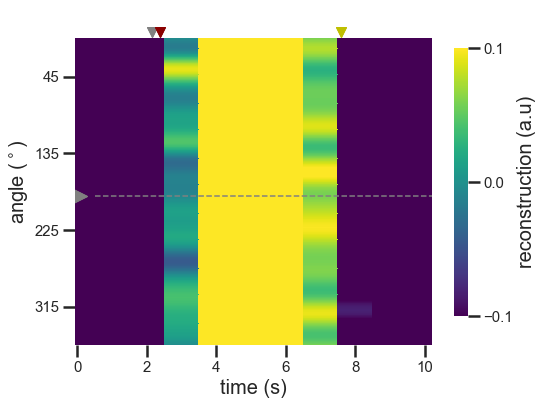

In [44]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

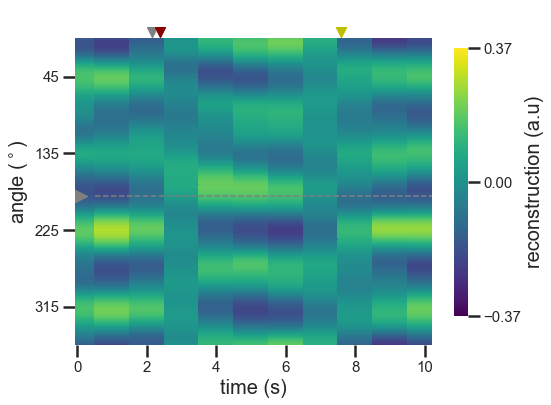

In [45]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

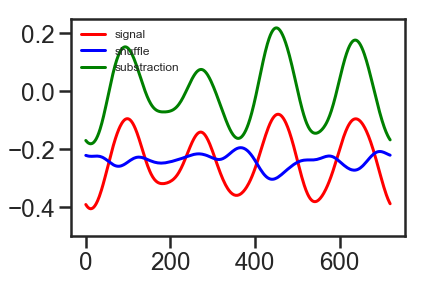

In [46]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

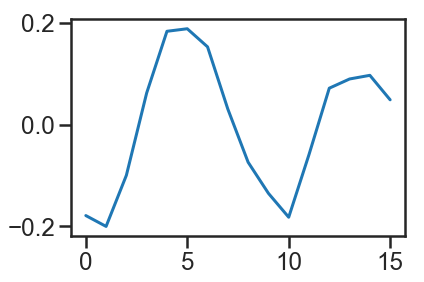

In [47]:
plt.plot(substr_shuffle.iloc[360-10:360+10, :].mean(axis=0))

### Shuffle (pick a random around the diagonal inside the free quadrant)

In [53]:
frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=1)
            ###
            ##align to other 
            ## 3- random in quadrant alone
            q_alone = list(set([1,2,3,4]) - set([reconstr_beh_cond['Q_DC'].iloc[trial], reconstr_beh_cond['Q_DF'].iloc[trial], reconstr_beh_cond['Q_DVF'].iloc[trial]]))[0]
            if q_alone==1:
                new_angle = np.random.randint(20,70)
            if q_alone==2:
                new_angle = np.random.randint(110,160)
            if q_alone==3:
                new_angle = np.random.randint(200,250)
            if q_alone==4:
                new_angle = np.random.randint(290, 340)
            ##
            ##                
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=1)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    

(89, 16, 720)
(96, 16, 720)
(96, 16, 720)
(74, 16, 720)
(83, 16, 720)
(80, 16, 720)


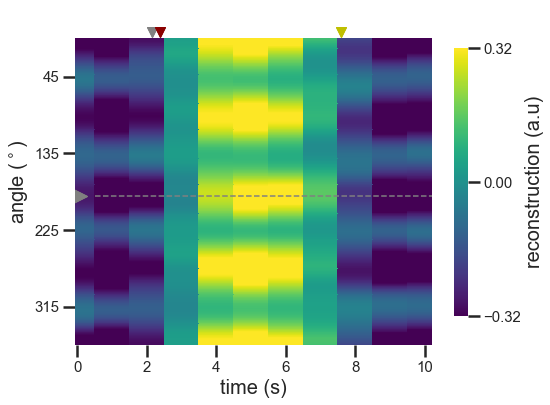

In [54]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

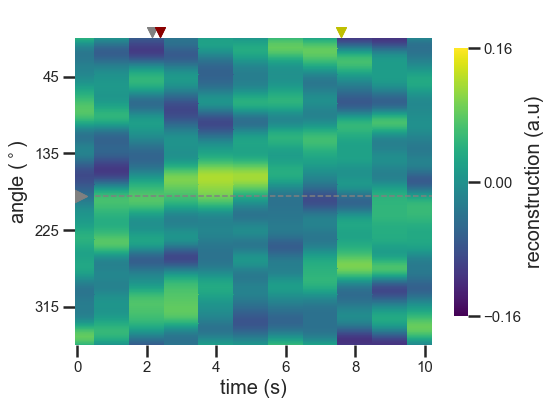

In [55]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

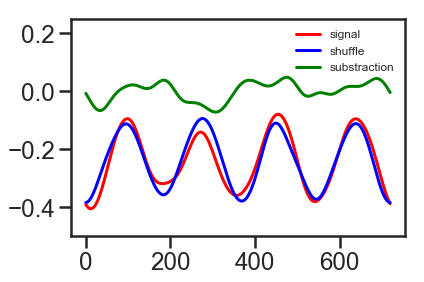

In [56]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

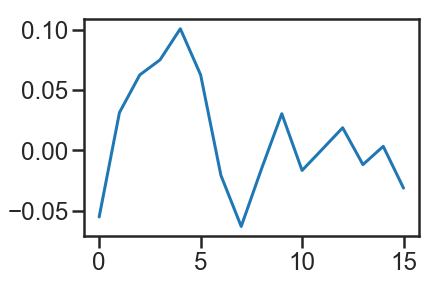

In [57]:
plt.plot(substr_shuffle.iloc[360-10:360+10, :].mean(axis=0))

### Shuffle (pick a random reference)

In [58]:
frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=1)
            ###
            ##                         
            new_angle = np.random.choice([0,90, 180, 270])
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=1)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    

(89, 16, 720)
(96, 16, 720)
(96, 16, 720)
(74, 16, 720)
(83, 16, 720)
(80, 16, 720)


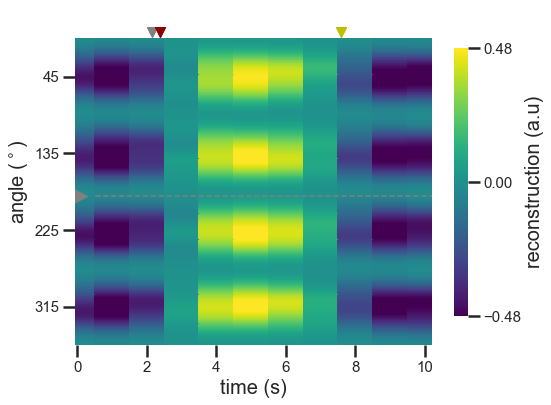

In [59]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

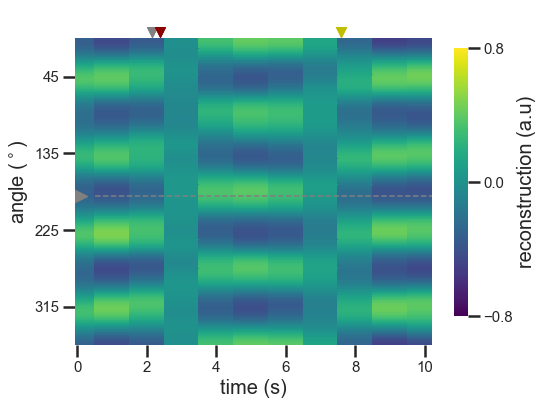

In [60]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

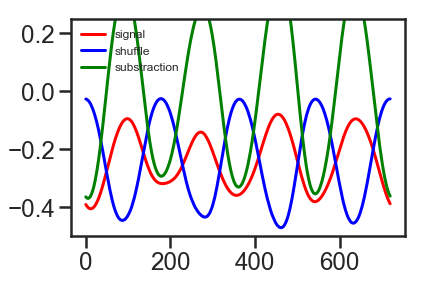

In [61]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

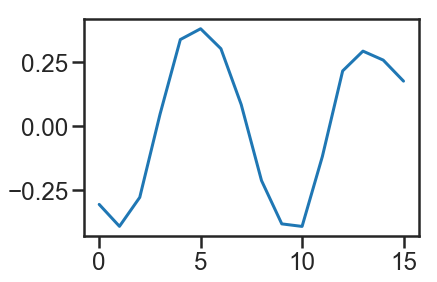

In [62]:
plt.plot(substr_shuffle.iloc[360-10:360+10, :].mean(axis=0))

In [ ]:
####  NEW AREA

In [289]:
recons_path =  'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\recs_IEM_trainT_testT_wm3_transtemp.npy' 

Reconstructions = np.load(recons_path, encoding='latin1')

print(np.shape(Reconstructions))
print(np.shape(Reconstructions[0]))

(6,)
(345, 16, 720)


In [291]:
beh_path =  'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\trainT_testT_behaviour_transtemp.xlsx' 
xl = pd.ExcelFile(beh_path)
sheet_names = xl.sheet_names

print(len(sheet_names))
beh_x = pd.read_excel(beh_path, sheet_name=sheet_names[0])
print(np.shape(beh_x))

6
(345, 46)


In [292]:
Condition_ = '1_0.2'
idx_transtemp = [0,1,2,3,4,5]
idx_area = idx_transtemp

In [293]:
frames=[]

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    #
    mean_reconstr_cond = reconstr_trials_cond.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames.append(dfx)


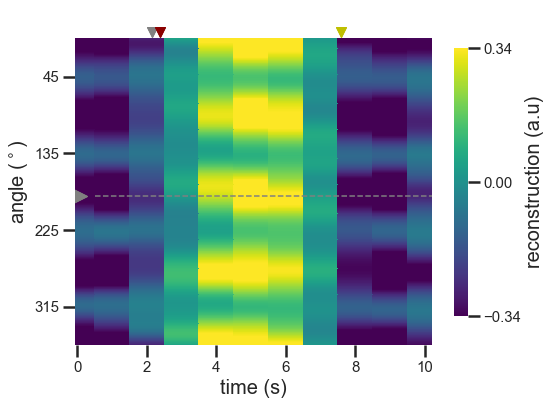

In [294]:
dfx_ = pd.concat(frames).groupby(level=0).mean()
Representation_heatmap(dfx_, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [315]:
n_shuffles=50

In [316]:
frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=0)
            ###
            ##align to other 
            ## 1 - Other target! (makes no sense! all equally relevant!)
            rch = np.random.choice([0,1,2]) ## T_alone es igual a a A_DVF, por lo que alineo a uno de los otros 2
            if rch == 0:
                colu_ = 'A_DC'
            elif rch == 1:
                colu_ = 'A_DF'
            elif rch == 2:
                colu_ = 'A_DVF'

            new_angle = reconstr_beh_cond[colu_].iloc[trial]
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=0)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    
        
        

(4450, 16, 720)
(4800, 16, 720)
(4800, 16, 720)
(3700, 16, 720)
(4150, 16, 720)
(4000, 16, 720)


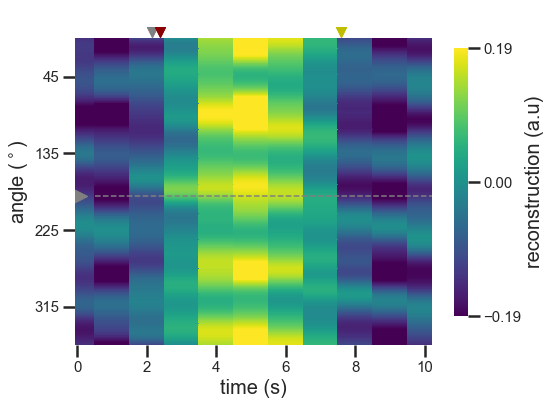

In [302]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

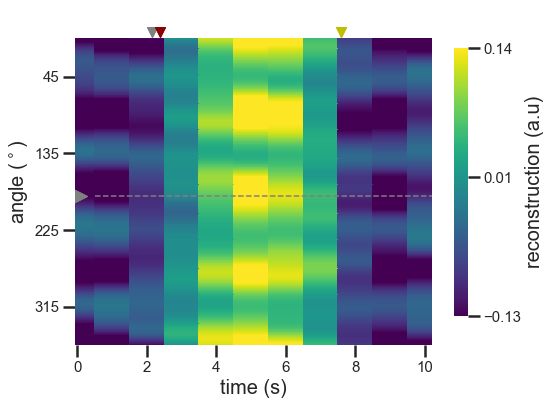

In [317]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

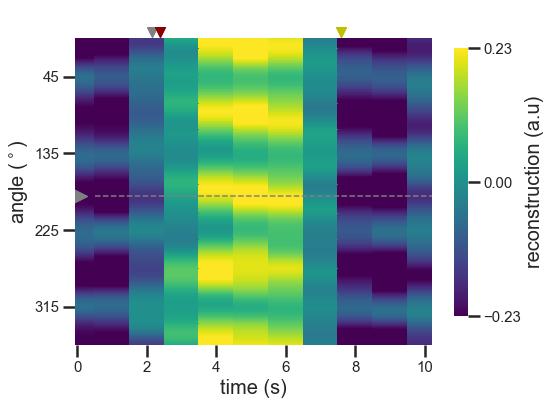

In [318]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

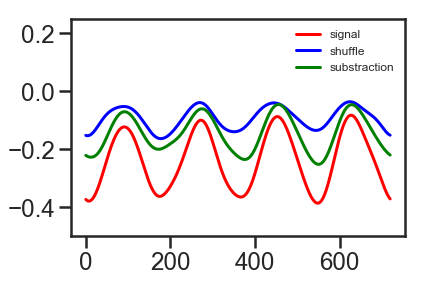

In [319]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

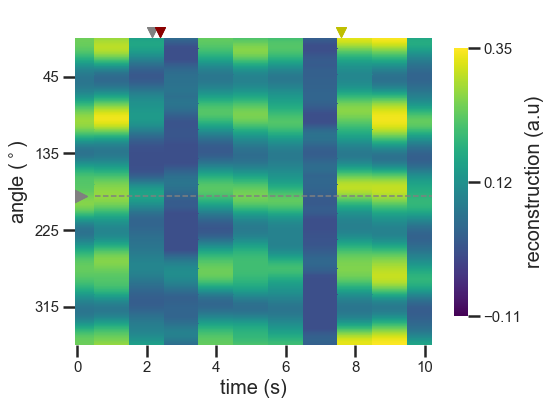

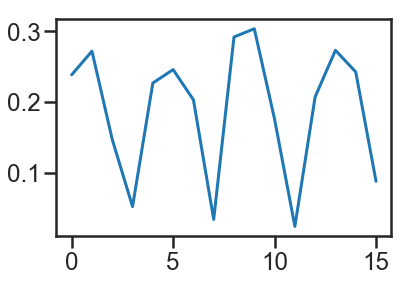

In [320]:
dfx3 = substr_shuffle.copy()

for col in range(np.shape(dfx)[1]):
    dfx3.iloc[:, col] = Pos_IEM2(substr_shuffle.iloc[:,col].values) 


Representation_heatmap(dfx3, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)
plt.plot(dfx3.iloc[360-10:360+10, :].mean(axis=0))


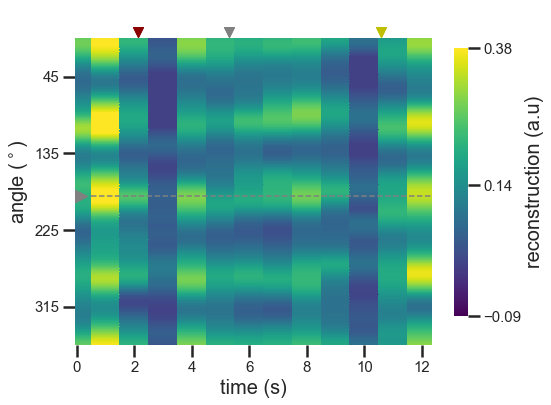

In [151]:
dfx3 = substr_shuffle.copy()

for col in range(np.shape(dfx)[1]):
    dfx3.iloc[:, col] = Pos_IEM2(substr_shuffle.iloc[:,col].values) 


Representation_heatmap(dfx3, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

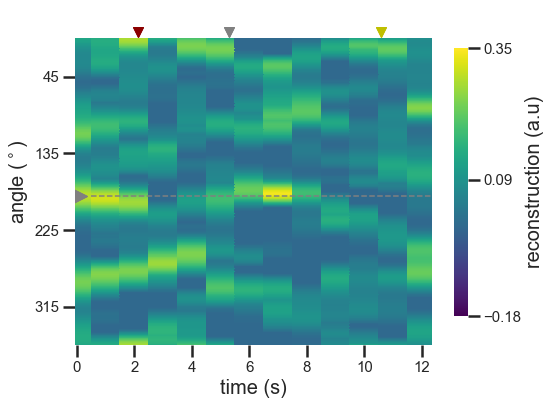

In [79]:
dfx3 = substr_shuffle.copy()

for col in range(np.shape(dfx)[1]):
    dfx3.iloc[:, col] = Pos_IEM2(dfx.iloc[:,col].values) 


Representation_heatmap(dfx3, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [13]:
### Methods de reconstruction

In [14]:
## default

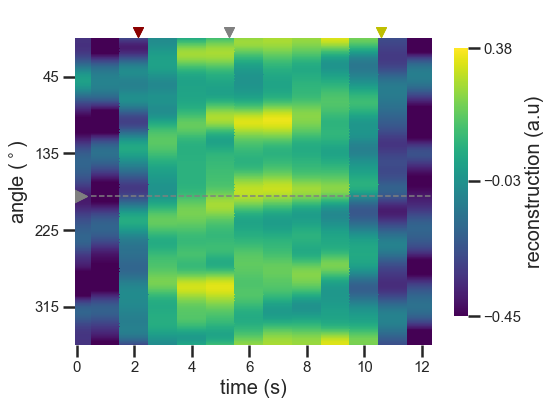

In [15]:
Representation_heatmap(dfx, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
##substract the weight matrix structure in each TR

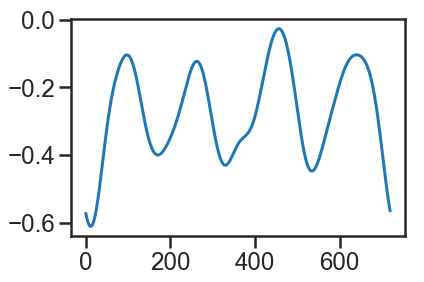

In [155]:
plt.plot(dfx.iloc[:,:3].mean(axis=1).values)

In [156]:
substr_structure = dfx.iloc[:,:3].mean(axis=1).values
dfx2 = dfx.copy()

for col in range(np.shape(dfx)[1]):
    dfx2.iloc[:, col] = dfx.iloc[:, col] - substr_structure

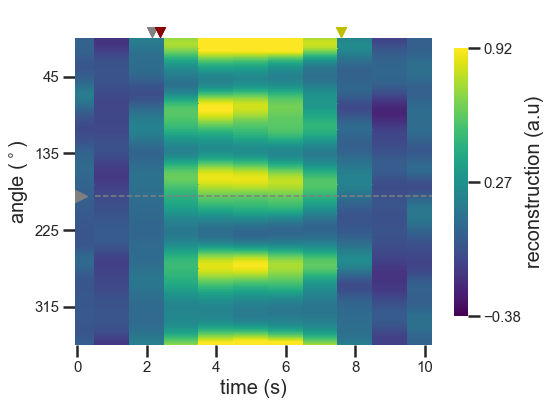

In [157]:
Representation_heatmap(dfx2, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
##Apply the POS function to each TR

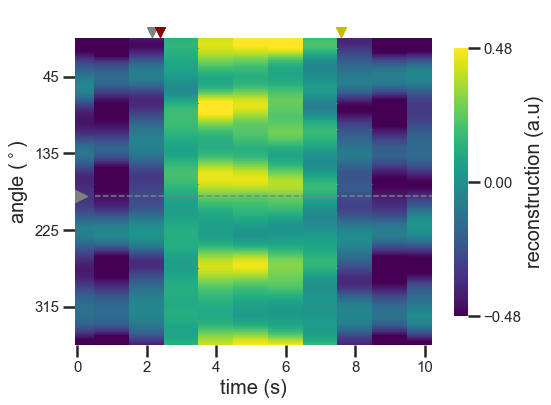

In [160]:
Representation_heatmap(dfx, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

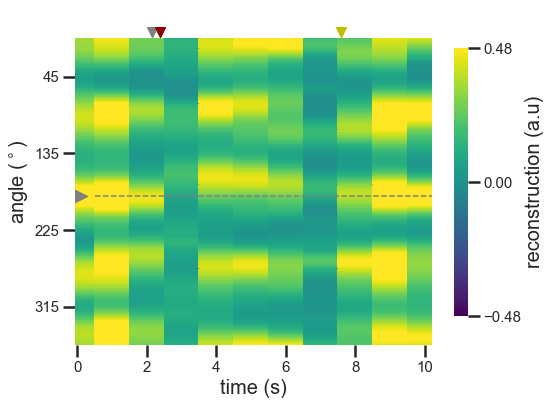

In [163]:
dfx3 = dfx.copy()

for col in range(np.shape(dfx)[1]):
    dfx3.iloc[:, col] = Pos_IEM2(dfx.iloc[:,col].values) 


Representation_heatmap(dfx3, condition=Condition_, max_ = 0.48, min_= -0.48, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
###it did not go exactly in the direction I expected!!! meh...

In [130]:
dfx

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.327216,-0.490157,-0.270901,-0.049685,0.055542,0.125394,0.245421,0.273012,0.251227,0.333764,0.205860,-0.253796,-0.672858,-0.574803,-0.079581,0.297343
1,-0.327655,-0.494599,-0.279045,-0.050284,0.062150,0.131840,0.247869,0.273214,0.250580,0.332086,0.203442,-0.256118,-0.673018,-0.574084,-0.079789,0.297664
2,-0.328200,-0.498994,-0.287191,-0.050742,0.068955,0.138324,0.250150,0.273310,0.249787,0.330053,0.200865,-0.258331,-0.672858,-0.573115,-0.079973,0.297908
3,-0.328666,-0.503065,-0.295045,-0.050966,0.075984,0.144788,0.252057,0.273131,0.248763,0.327508,0.197984,-0.260368,-0.672046,-0.571367,-0.080010,0.297740
4,-0.329265,-0.507121,-0.302893,-0.050934,0.083340,0.151322,0.253798,0.272927,0.247649,0.324495,0.194728,-0.262460,-0.670945,-0.569281,-0.079870,0.297644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-0.325168,-0.466495,-0.229603,-0.043482,0.027220,0.094664,0.229771,0.269681,0.251676,0.334115,0.212667,-0.240940,-0.664979,-0.569871,-0.075446,0.293197
716,-0.325546,-0.471436,-0.237863,-0.045061,0.032250,0.100565,0.233313,0.270671,0.251989,0.335070,0.211925,-0.243783,-0.667528,-0.571877,-0.076587,0.294407
717,-0.325860,-0.476138,-0.246094,-0.046521,0.037559,0.106565,0.236613,0.271438,0.252017,0.335469,0.210873,-0.246429,-0.669456,-0.573249,-0.077519,0.295387
718,-0.326360,-0.481036,-0.254424,-0.047819,0.043216,0.112782,0.239803,0.272194,0.252035,0.335455,0.209522,-0.248985,-0.671113,-0.574330,-0.078332,0.296195


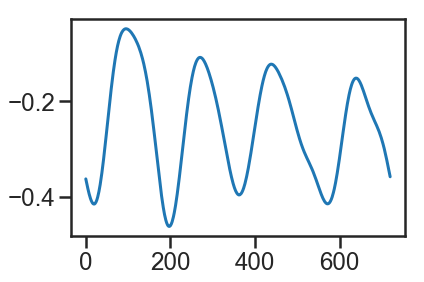

In [146]:
# substract to each column??



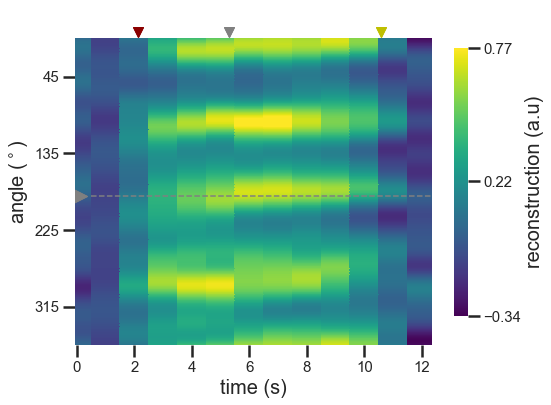

In [149]:
Representation_heatmap(dfx2, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

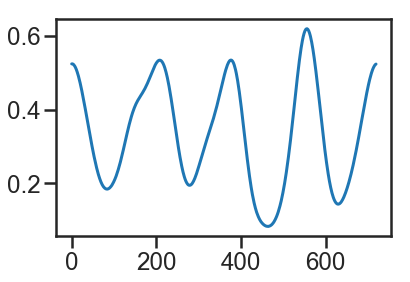

In [136]:
posx = Pos_IEM2(dfx.iloc[:,1].values)
plt.plot(posx)

In [ ]:
## Apply the POS to the final recosntruction

In [13]:
## Apply the POS to each trial reconstruction and mean the final one

In [7]:
sep_channels=10
adjusted_size_contant = 48.519

pos_channels = np.arange(sep_channels/2,360,sep_channels)
pos_channels = [round(pos_channels[i],3) for i in range(0, len(pos_channels))]

pos_channels2 = np.arange(0,360,0.5)
pos_channels2 = [round(pos_channels2[i],3) for i in range(0, len(pos_channels2))]

def posch1_to_posch2(ch_1):
    return np.where(np.array(pos_channels2) == pos_channels[ch_1])[0][0]


def Representation_heatmap(df, condition='1_0.2', min_=None, max_=None, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15):
    ##
    ##
    ##### pal_cyan = sns.color_palette("RdBu_r", n_colors=200)[40:] #RdBu_r
    pal_cyan = 'viridis'
    #
    if min_==None:
        min_ = np.round(df.mean().mean()-4*df.std().mean(),2)
    if max_==None:
        max_ = np.round(df.mean().mean()+4*df.std().mean(),2)
    #
    middle = np.round( min_ + ((abs(max_)+abs(min_))/2), 2)
    ##
    ##
    
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(df, cmap=pal_cyan, 
                     vmin=min_, 
                     vmax=max_,
                     cbar=True, 
                cbar_kws={"shrink": .82, 'ticks' : [min_, middle, max_], 'label': 'reconstruction (a.u)'})
    ax.figure.axes[-1].yaxis.label.set_size(fs1)
    ax.figure.axes[-1].tick_params(labelsize=fs2)
    
    plt.gca().set_ylabel('')
    plt.yticks([posch1_to_posch2(4), posch1_to_posch2(13), posch1_to_posch2(22), posch1_to_posch2(31)],['45','135','225', '315'])

    dims=np.shape(df)
    dimN = dims[0]
    plt.gca().set_ylim(dimN, -45)
    
    plt.plot([0.5, 0.5], [posch1_to_posch2(18),posch1_to_posch2(18)], markersize=20, color='grey', marker='>')
    plt.plot([1, 23.5], [posch1_to_posch2(18),posch1_to_posch2(18)], color='grey', linestyle='--', linewidth=1.5)
    
    ################################
    presentation_period= 0.35 #stim presnetation time
    presentation_period_cue=  0.50 #presentation of attentional cue time
    pre_stim_period= 0.5 #time between cue and stim
    resp_time = 4  #time the response is active
    start_hrf = 4  #start of the Hemodynamic response (4seconds)
    if condition == '1_0.2':
        condition_title = 'o:1, d:0.2'
        delay1 = 0.2
        delay2 = 11.8
        cue=0
        t_p = cue + presentation_period_cue + pre_stim_period 
        d_p = t_p + presentation_period +delay1 
        r_t = d_p + presentation_period + delay2
        xlim = [1/TR, 25/TR]
    elif condition=='1_7':
        condition_title = 'o:1, d:7'
        delay1 = 7
        delay2 = 5
        cue=0
        t_p = cue + presentation_period_cue + pre_stim_period 
        d_p = t_p + presentation_period +delay1 
        r_t = d_p + presentation_period + delay2
        xlim = [1/TR, 25/TR]
    elif condition=='2_0.2':
        condition_title = 'o:2, d:0.2'
        delay1 = 0.2
        delay2 = 12
        cue=0
        d_p = cue + presentation_period_cue + pre_stim_period 
        t_p = d_p + presentation_period +delay1 
        r_t = t_p + presentation_period + delay2   
        xlim = [1/TR, 25/TR]
    elif condition=='2_7':
        condition_title = 'o:2, d:7'
        delay1 = 7
        delay2 = 12
        cue=0
        d_p = cue + presentation_period_cue + pre_stim_period 
        t_p = d_p + presentation_period +delay1 
        r_t = t_p + presentation_period + delay2
        xlim = [1/TR, 30/TR]
    ##
    ##
    t_p1 = (start_hrf + t_p) ## strat of target (time)
    d_p1 = (start_hrf + d_p) ##strat of didtractor (time)
    r_p1=  (start_hrf + r_t) ## start of response (time)
    ##
    plt.plot([t_p1/TR +bin_,t_p1/TR+bin_], [-15,-15], markersize=10, color='grey', marker='v')
    plt.plot([d_p1/TR +bin_,d_p1/TR+bin_], [-15,-15], markersize=10, color='darkred', marker='v')
    plt.plot([r_p1/TR +bin_,r_p1/TR+bin_], [-15,-15], markersize=10, color='y', marker='v')
    plt.gca().set_xlim(xlim)
    
    plt.xticks(fontsize=fs2)
    plt.yticks(fontsize=fs2)
    plt.gca().set_ylabel('angle ($^\circ$)', fontsize=fs1)
    plt.gca().set_xlabel('time (s)', fontsize=fs1)
    #plt.title(condition_title)
    
    plt.show()


In [8]:
def Pos_IEM2( channel_reconstruction ):
    # make it all positive
    # negative values are positive in somwhere else
    all_channels = list(np.arange(0, len(channel_reconstruction), 1))
    half_ = len(all_channels)/2
    new_ = np.zeros((len(all_channels)))
    #
    POS_channel_reconstruction = list(channel_reconstruction)
    #
    all_channels=list(all_channels)
    #
    #
    for ch in all_channels:
        value_ch = POS_channel_reconstruction[ch]
        if value_ch>0:
            new_[ch] = new_[ch] + value_ch
        if value_ch<0:            
            if ch<half_:
                new_[int(ch+half_)] = new_[int(ch+half_)] - value_ch
            if ch>=half_:
                new_[int(ch-half_)] = new_[int(ch-half_)] - value_ch
    ###
    return new_

